In [2]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [3]:
from pytorch_msssim import ms_ssim
import torch
import lpips

l1_criterion = torch.nn.L1Loss(reduction='mean')
l2_criterion = torch.nn.MSELoss(reduction='mean')
initial_batch_size = 2

def rec_loss(attr_images, generated_images, a):
    ms_ssim_loss = 1 - ms_ssim(attr_images, generated_images, data_range=1, size_average=True)
    l1_loss_value = l1_criterion(attr_images, generated_images)
    return a * ms_ssim_loss + (1 - a) * l1_loss_value


def id_loss(encoded_input_image, encoded_generated_image):
    return l1_criterion(encoded_input_image, encoded_generated_image)


def landmark_loss(input_attr_lnd, output_lnd):
    loss = l2_criterion(input_attr_lnd, output_lnd)
    return loss


def l2_loss(attr_images, generated_images):
    loss = l2_criterion(attr_images, generated_images)
    return loss

def normalize(cond, conds_mean, conds_std):
    cond = (cond - conds_mean) / conds_std
    return cond

def denormalize(cond, conds_mean, conds_std):
    cond = (cond * conds_std) + conds_mean
    return cond

In [4]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')

from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.LatentMapperNew1 import LatentMapper
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.to(device)
model.ema_model.eval()


conds_mean = torch.load('FFHQ_xT_data/conds_mean.pt').to(device)
conds_std = torch.load('FFHQ_xT_data/conds_std.pt').to(device)

BASE_PATH = '/home/joshua/Projects/diffae/disentanglement/'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)

mlp = LatentMapper(dropout_rate=0.1, batch_size=initial_batch_size)
mlp = torch.load('/home/joshua/Projects/diffae/checkpoints/MLP/ID_VEC_ffhq70000_mlp.pt')

id_encoder = id_encoder.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)


id_encoder = id_encoder.eval()
lpips_loss = lpips.LPIPS(net='alex').to(Global_Config.device).eval()

mlp = mlp.train()

Global seed set to 0


Model params: 160.69 M
Loading ResNet ArcFace
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
mlp

LatentMapper(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_featu

In [6]:
import torch.nn as nn
L2 = nn.MSELoss()

config = {
    'beta1' : 0.5,
    'beta2' : 0.999,
    'lrD' : 0.0004,
    'lrMLP' : 0.3,
    'lrmlp' : 0.1,
    'lrAttr' : 0.0001,
    'non_adverserial_lr': 6e-5,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 8,
    'R1Param' : 10,
    'lambdaID' : 1,
    'lambdaLND' : 0.02,
    'lambdaREC' : 0.2,
    'lambdaL2' : 1,
    'lambdaVGG' : 0.2,
    'lambdalatent' : 10,
    'a': 0.84
}

optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=config['lrMLP'], betas=(config['beta1'], config['beta2']))
optimizermlp = torch.optim.SGD(mlp.parameters(), lr=config['lrmlp'])

In [7]:
# load image data 70000
conf = ffhq256_autoenc()
image_data = conf.make_dataset()
for idx, data in enumerate(image_data):
    if idx == 1:
        break
    print(data)

{'img': tensor([[[-0.9686, -1.0000, -0.9843,  ..., -0.9843, -0.9922, -0.9843],
         [-0.9765, -1.0000, -0.9922,  ..., -0.9922, -1.0000, -0.9922],
         [-0.9686, -0.9922, -1.0000,  ..., -0.9922, -1.0000, -1.0000],
         ...,
         [-0.8275, -0.8196, -0.8118,  ...,  0.0196,  0.0275,  0.0353],
         [-0.8745, -0.8588, -0.8510,  ...,  0.0667,  0.0824,  0.0745],
         [-0.8745, -0.8667, -0.8588,  ...,  0.0275,  0.0588,  0.0510]],

        [[ 0.0275, -0.0275,  0.0118,  ..., -0.0667, -0.0980, -0.0902],
         [ 0.0196, -0.0118,  0.0039,  ..., -0.0980, -0.1137, -0.0980],
         [ 0.0275,  0.0039, -0.0039,  ..., -0.1137, -0.1216, -0.1216],
         ...,
         [ 0.2078,  0.2157,  0.2235,  ...,  0.2157,  0.2157,  0.2235],
         [ 0.1529,  0.1686,  0.1765,  ...,  0.2549,  0.2471,  0.2392],
         [ 0.1529,  0.1608,  0.1686,  ...,  0.2157,  0.2235,  0.2157]],

        [[ 0.1451,  0.0902,  0.1451,  ...,  0.2078,  0.1843,  0.1922],
         [ 0.1373,  0.1059,  0.1373, 

In [8]:
def print_grad(grad):
    print('Gradient mean:', torch.mean(grad))
    print('Gradient std:', torch.std(grad))

# 在模型中注册梯度回调函数

## Train Loop Step 1

In [66]:
import matplotlib.pyplot as plt

# torch.manual_seed(1)

id_list = []
semantic_vec_true_list = []
semantic_vec_list = []
# semantic_normalize_list = []

#————————————————————————————————————————————
# 设置loss记录列表

id_loss_list = []
rec_loss_list = []
l2_loss_list = []
latent_loss_list = []
vgg_loss_list = []
landmark_loss_list = []
total_loss_list = []

#————————————————————————————————————————————
epochs = 1
batch_size = 4  # 设置批量大小
total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)

for epoch in range(epochs):
    batch = []  # 初始化一个空的批量列表
    for idx, data in enumerate(image_data):
        img = data['img'][None]
        batch.append(img)
        # 当批量列表中有足够数量的数据时，堆叠它们形成一个批量
        if len(batch) == batch_size:
            batch_tensor = torch.cat(batch, dim=0)
            torch.cuda.empty_cache()
            id_images = batch_tensor.cuda()

#             diff_batch = image_data[idx]['img'][None]
            attr_batch = batch_tensor*0.5+0.5
            attr_images = attr_batch.cuda()

            total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)
            optimizerMLP.zero_grad()


            with torch.no_grad():
                id_vec = id_encoder.extract_feats(id_images)   # -1 to 1
                semantic_vec_true = model.encode(attr_images*2-1)
                encoded_vec = torch.cat((id_vec,semantic_vec_true), dim=1)
                
#             real_landmarks, real_landmarks_nojawline = landmark_encoder(attr_images)
            
            semantic_vec = mlp(encoded_vec)

    #         semantic_normalize = normalize(semantic_vec, conds_mean, conds_std)

            # record the data
#             id_list.append(id_vec.detach().cpu())
            semantic_vec_true_list.append(semantic_vec_true.detach().cpu())
            semantic_vec_list.append(semantic_vec.detach().cpu())
    #         semantic_normalize_list.append(semantic_normalize.detach().cpu())

#             generated_landmarks, generated_landmarks_nojawline = landmark_encoder(generated_img)
#_______________________________
# Select the losses to use
            ## -1 to 1
#             id_loss_val = config['lambdaID'] * id_encoder(generated_img_det*2-1, id_images)
#             total_loss += id_loss_val

            ## 0 to 1
#             rec_loss_val = config['lambdaREC'] * rec_loss(ori_img, generated_img_det, config['a'])
#             total_loss += rec_loss_val

#             l2_loss_val = config['lambdaL2'] * l2_loss(ori_img, generated_img_det)
#             total_loss += l2_loss_val

            latent_loss = config['lambdalatent'] * l2_loss(semantic_vec, semantic_vec_true)
            total_loss += latent_loss
            ## -1 to 1
#             vgg_loss_val = torch.mean(config['lambdaVGG'] * lpips_loss(generated_img*2-1, attr_images*2-1))
#             total_loss += vgg_loss_val
            
#             landmark_loss_val = config['lambdaLND'] * landmark_loss(generated_landmarks_nojawline, real_landmarks_nojawline)
#             total_loss += landmark_loss_val
            
            total_loss.backward()
            model.zero_grad()
            id_encoder.zero_grad()
            optimizerMLP.step()
            for name, param in mlp.named_parameters():
                if param.requires_grad and param.grad is not None:
                    print('Layer:', name, 'Gradient mean:', param.grad.mean(), 'Gradient std:', param.grad.std())
            
#             id_loss_list.append(id_loss_val.item())
#             rec_loss_list.append(rec_loss_val.item())
#             l2_loss_list.append(l2_loss_val.item())
            latent_loss_list.append(latent_loss.item())
#             vgg_loss_list.append(vgg_loss_val.item())
#             landmark_loss_list.append(landmark_loss_val.item())
            total_loss_list.append(total_loss.item())
            batch = []

        if idx % 10 == 0:
            print("toal loss:", total_loss.item(), 'idx:', idx)
#                 print('latent_loss:', latent_loss.item(), 'id_loss_val:',id_loss_val.item(),
#                       'rec_loss_val:',rec_loss_val.item(),'l2_loss_val:',l2_loss_val.item(),
#                       'vgg_loss_val:',vgg_loss_val.item(),'landmark_loss_val:',landmark_loss_val.item())

toal loss: 0.0 idx: 0
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0023, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
G

Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-05, device='cuda:0')
Gradient mean: tensor(-1.3454e-07, device='cuda:0')
Gradient std: tensor(1.1079e-0

Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device='cuda:0')
Gradient std: tensor(1.5653e-05, device='cuda:0')
Gradient mean: tensor(8.8241e-08, device=

Gradient std: tensor(2.7318e-06, device='cuda:0')
Gradient mean: tensor(7.2879e-09, device='cuda:0')
Gradient std: tensor(2.7318e-06, device='cuda:0')
Gradient mean: tensor(7.2879e-09, device='cuda:0')
Gradient std: tensor(2.7318e-06, device='cuda:0')
Gradient mean: tensor(7.2879e-09, device='cuda:0')
Gradient std: tensor(2.7318e-06, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device='cuda:0')
Gradient std: tensor(1.3506e-05, device='cuda:0')
Gradient mean: tensor(7.3325e-08, device=

Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tensor(-3.1461e-05, device='cuda:0')
Gradient std: tensor(0.0022, device='cuda:0')
Gradient mean: tenso

Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device='cuda:0')
Gradient mean: tensor(4.8316e-07, device='cuda:0')
Gradient std: tensor(2.7564e-05, device=

Gradient mean: tensor(3.4537e-07, device='cuda:0')
Gradient std: tensor(1.6080e-05, device='cuda:0')
Gradient mean: tensor(3.4537e-07, device='cuda:0')
Gradient std: tensor(1.6080e-05, device='cuda:0')
Gradient mean: tensor(3.4537e-07, device='cuda:0')
Gradient std: tensor(1.6080e-05, device='cuda:0')
Gradient mean: tensor(3.4537e-07, device='cuda:0')
Gradient std: tensor(1.6080e-05, device='cuda:0')
Gradient mean: tensor(3.4537e-07, device='cuda:0')
Gradient std: tensor(1.6080e-05, device='cuda:0')
Gradient mean: tensor(-4.2592e-15, device='cuda:0')
Gradient std: tensor(2.1220e-12, device='cuda:0')
Gradient mean: tensor(-4.2592e-15, device='cuda:0')
Gradient std: tensor(2.1220e-12, device='cuda:0')
Gradient mean: tensor(-4.2592e-15, device='cuda:0')
Gradient std: tensor(2.1220e-12, device='cuda:0')
Gradient mean: tensor(-4.2592e-15, device='cuda:0')
Gradient std: tensor(2.1220e-12, device='cuda:0')
Gradient mean: tensor(-4.2592e-15, device='cuda:0')
Gradient std: tensor(2.1220e-12, de

Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-05, device='cuda:0')
Gradient mean: tensor(-5.1424e-09, device='cuda:0')
Gradient std: tensor(1.3142e-0

Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(8.8658e-05, device='cuda:0')
Gradient std: tensor(0.0019, d

Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-07, device='cuda:0')
Gradient std: tensor(1.4636e-05, device='cuda:0')
Gradient mean: tensor(-4.7497e-0

Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-06, device='cuda:0')
Gradient mean: tensor(-5.9572e-10, device='cuda:0')
Gradient std: tensor(2.6406e-0

Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-11, device='cuda:0')
Gradient mean: tensor(-2.9934e-13, device='cuda:0')
Gradient std: tensor(2.1249e-1

Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tensor(-1.1964e-05, device='cuda:0')
Gradient std: tensor(0.0013, device='cuda:0')
Gradient mean: tenso

Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device='cuda:0')
Gradient mean: tensor(4.5663e-08, device='cuda:0')
Gradient std: tensor(7.8471e-06, device=

Gradient std: tensor(9.1361e-06, device='cuda:0')
Gradient mean: tensor(1.2974e-08, device='cuda:0')
Gradient std: tensor(9.1361e-06, device='cuda:0')
Gradient mean: tensor(1.2974e-08, device='cuda:0')
Gradient std: tensor(9.1361e-06, device='cuda:0')
Gradient mean: tensor(1.2974e-08, device='cuda:0')
Gradient std: tensor(9.1361e-06, device='cuda:0')
Gradient mean: tensor(1.2974e-08, device='cuda:0')
Gradient std: tensor(9.1361e-06, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, device='cuda:0')
Gradient std: tensor(4.3680e-13, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, device='cuda:0')
Gradient std: tensor(4.3680e-13, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, device='cuda:0')
Gradient std: tensor(4.3680e-13, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, device='cuda:0')
Gradient std: tensor(4.3680e-13, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, device='cuda:0')
Gradient std: tensor(4.3680e-13, device='cuda:0')
Gradient mean: tensor(-4.7021e-15, d

Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(4.1574e-

Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-05, device='cuda:0')
Gradient mean: tensor(-7.1588e-07, device='cuda:0')
Gradient std: tensor(1.6594e-0

Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device='cuda:0')
Gradient std: tensor(2.2632e-06, device='cuda:0')
Gradient mean: tensor(1.2144e-08, device=

Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-12, device='cuda:0')
Gradient std: tensor(1.1527e-10, device='cuda:0')
Gradient mean: tensor(-1.4673e-1

Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean:

Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-08, device='cuda:0')
Gradient std: tensor(4.6583e-06, device='cuda:0')
Gradient mean: tensor(-1.9695e-0

Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-06, device='cuda:0')
Gradient mean: tensor(-5.4303e-08, device='cuda:0')
Gradient std: tensor(5.7024e-0

Layer: model.0.weight Gradient mean: tensor(-6.6592e-09, device='cuda:0') Gradient std: tensor(3.7491e-06, device='cuda:0')
Layer: model.0.bias Gradient mean: tensor(1.5879e-12, device='cuda:0') Gradient std: tensor(5.4191e-11, device='cuda:0')
Layer: model.1.weight Gradient mean: tensor(1.9668e-11, device='cuda:0') Gradient std: tensor(9.8339e-06, device='cuda:0')
Layer: model.1.bias Gradient mean: tensor(2.4796e-08, device='cuda:0') Gradient std: tensor(6.2164e-06, device='cuda:0')
Layer: model.4.weight Gradient mean: tensor(-4.7989e-09, device='cuda:0') Gradient std: tensor(1.8796e-06, device='cuda:0')
Layer: model.4.bias Gradient mean: tensor(-1.0963e-14, device='cuda:0') Gradient std: tensor(4.3237e-13, device='cuda:0')
Layer: model.5.weight Gradient mean: tensor(5.2817e-08, device='cuda:0') Gradient std: tensor(9.0126e-06, device='cuda:0')
Layer: model.5.bias Gradient mean: tensor(-5.4303e-08, device='cuda:0') Gradient std: tensor(5.7024e-06, device='cuda:0')
Layer: model.8.weigh

Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device='cuda:0')
Gradient std: tensor(4.5079e-12, device='cuda:0')
Gradient mean: tensor(1.7690e-13, device=

Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device='cuda:0')
Gradient std: tensor(1.8546e-05, device='cuda:0')
Gradient mean: tensor(2.1931e-07, device=

Gradient mean: tensor(-3.5196e-15, device='cuda:0')
Gradient std: tensor(2.5461e-13, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device='cuda:0')
Gradient mean: tensor(6.6792e-10, device='cuda:0')
Gradient std: tensor(2.0870e-06, device

Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std

Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device='cuda:0')
Gradient std: tensor(1.9503e-05, device='cuda:0')
Gradient mean: tensor(4.7699e-07, device=

Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device='cuda:0')
Gradient std: tensor(5.4684e-13, device='cuda:0')
Gradient mean: tensor(6.0400e-15, device=

Gradient mean: tensor(4.1180e-09, device='cuda:0')
Gradient std: tensor(9.6141e-06, device='cuda:0')
Gradient mean: tensor(4.1180e-09, device='cuda:0')
Gradient std: tensor(9.6141e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device='cuda:0')
Gradient mean: tensor(7.4208e-08, device='cuda:0')
Gradient std: tensor(6.2239e-06, device=

Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-05, device='cuda:0')
Gradient mean: tensor(-1.7920e-07, device='cuda:0')
Gradient std: tensor(4.9609e-0

Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-07, device='cuda:0')
Gradient std: tensor(1.2618e-05, device='cuda:0')
Gradient mean: tensor(-1.7348e-0

Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device='cuda:0')
Gradient mean: tensor(4.7309e-08, device='cuda:0')
Gradient std: tensor(9.9040e-06, device=

Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-11, device='cuda:0')
Gradient mean: tensor(-5.9923e-13, device='cuda:0')
Gradient std: tensor(3.2621e-1

Gradient mean: tensor(-0.0006, device='cuda:0')
Gradient std: tensor(0.0015, device='cuda:0')
Gradient mean: tensor(-0.0006, device='cuda:0')
Gradient std: tensor(0.0015, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std: tensor(0.0014, device='cuda:0')
Gradient mean: tensor(-0.0003, device='cuda:0')
Gradient std

Gradient mean: tensor(5.7013e-14, device='cuda:0')
Gradient std: tensor(1.0650e-12, device='cuda:0')
Gradient mean: tensor(5.7013e-14, device='cuda:0')
Gradient std: tensor(1.0650e-12, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06, device='cuda:0')
Gradient mean: tensor(-8.8631e-09, device='cuda:0')
Gradient std: tensor(6.6384e-06,

Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device='cuda:0')
Gradient mean: tensor(1.0028e-07, device='cuda:0')
Gradient std: tensor(7.6504e-06, device=

Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device='cuda:0')
Gradient mean: tensor(9.2239e-09, device='cuda:0')
Gradient std: tensor(4.2739e-06, device=

Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device='cuda:0')
Gradient std: tensor(1.2674e-11, device='cuda:0')
Gradient mean: tensor(4.6992e-13, device=

Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-07, device='cuda:0')
Gradient std: tensor(2.4330e-05, device='cuda:0')
Gradient mean: tensor(-1.6995e-0

Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-08, device='cuda:0')
Gradient std: tensor(2.1298e-06, device='cuda:0')
Gradient mean: tensor(-1.9594e-0

Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std

Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device='cuda:0')
Gradient std: tensor(3.3216e-05, device='cuda:0')
Gradient mean: tensor(1.5478e-06, device=

Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device='cuda:0')
Gradient std: tensor(5.9882e-06, device='cuda:0')
Gradient mean: tensor(2.3715e-08, device=

Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device='cuda:0')
Gradient mean: tensor(3.4673e-07, device='cuda:0')
Gradient std: tensor(1.2902e-05, device=

Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0010, device='cuda:0')
Gradient mean:

Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(2.8173e-14, device='cuda:0')
Gradient std: tensor(1.0328e-12, device='cuda:0')
Gradient mean: tensor(6.8639e-08, device='cuda:0')
Gradient std: tensor(4.8796e-06, device='cuda:0')
Gradient mean: tensor(6.8639e-08, device='cuda:0')
Gradient std: tensor(4.8796e-06, device='cuda:0')
Gradient mean: tensor(6.8639e-08, device=

Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device='cuda:0')
Gradient std: tensor(6.6285e-06, device='cuda:0')
Gradient mean: tensor(9.9487e-08, device=

Layer: model.0.weight Gradient mean: tensor(2.2957e-08, device='cuda:0') Gradient std: tensor(4.2192e-06, device='cuda:0')
Layer: model.0.bias Gradient mean: tensor(-3.5577e-13, device='cuda:0') Gradient std: tensor(9.6459e-11, device='cuda:0')
Layer: model.1.weight Gradient mean: tensor(-1.6793e-08, device='cuda:0') Gradient std: tensor(9.8851e-06, device='cuda:0')
Layer: model.1.bias Gradient mean: tensor(-2.0651e-07, device='cuda:0') Gradient std: tensor(6.5439e-06, device='cuda:0')
Layer: model.4.weight Gradient mean: tensor(-1.4505e-08, device='cuda:0') Gradient std: tensor(1.8850e-06, device='cuda:0')
Layer: model.4.bias Gradient mean: tensor(2.9189e-15, device='cuda:0') Gradient std: tensor(3.5586e-13, device='cuda:0')
Layer: model.5.weight Gradient mean: tensor(-1.1979e-07, device='cuda:0') Gradient std: tensor(1.0162e-05, device='cuda:0')
Layer: model.5.bias Gradient mean: tensor(9.9487e-08, device='cuda:0') Gradient std: tensor(6.6285e-06, device='cuda:0')
Layer: model.8.weig

Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device='cuda:0')
Gradient std: tensor(2.5448e-12, device='cuda:0')
Gradient mean: tensor(1.8251e-13, device=

Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(9.2962e-07, device='cuda:0')
Gradient std: tensor(2.6303e-05, device='cuda:0')
Gradient mean: tensor(8.1338e-07, device='cuda:0')
Gradient std: tensor(1.6399e-05, device='cuda:0')
Gradient mean: tensor(8.1338e-07, device='cuda:0')
Gradient std: tensor(1.6399e-05, device=

Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-06, device='cuda:0')
Gradient mean: tensor(-5.6311e-09, device='cuda:0')
Gradient std: tensor(2.2480e-0

Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(-5.3654e-05, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tenso

Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device='cuda:0')
Gradient mean: tensor(1.9530e-07, device='cuda:0')
Gradient std: tensor(2.1987e-05, device=

Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device='cuda:0')
Gradient mean: tensor(1.3165e-08, device='cuda:0')
Gradient std: tensor(3.2342e-06, device=

Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device='cuda:0')
Gradient std: tensor(7.3891e-06, device='cuda:0')
Gradient mean: tensor(3.4794e-08, device=

Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device='cuda:0')
Gradient std: tensor(4.7174e-05, device='cuda:0')
Gradient mean: tensor(1.1819e-06, device=

Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-05, device='cuda:0')
Gradient mean: tensor(-1.0506e-07, device='cuda:0')
Gradient std: tensor(1.1406e-0

Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-06, device='cuda:0')
Gradient mean: tensor(-4.9596e-08, device='cuda:0')
Gradient std: tensor(7.9324e-0

Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device='cuda:0')
Gradient mean: tensor(6.4315e-13, device='cuda:0')
Gradient std: tensor(2.4280e-11, device=

Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.0009, device='cuda:0')
Gradient std: tensor(0.0018, device='cuda:0')
Gradient mean: tensor(0.

Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(1.8170e-08, device='cuda:0')
Gradient std: tensor(6.4414e-06, device='cuda:0')
Gradient mean: tensor(9.1204e-08, device='cuda:0')
Gradient std: tensor(2.3780e-05, device=

Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-15, device='cuda:0')
Gradient std: tensor(4.3191e-13, device='cuda:0')
Gradient mean: tensor(-3.5179e-1

Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0019, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.

Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-07, device='cuda:0')
Gradient std: tensor(1.6782e-05, device='cuda:0')
Gradient mean: tensor(-1.7466e-0

Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device='cuda:0')
Gradient std: tensor(2.2400e-06, device='cuda:0')
Gradient mean: tensor(4.8164e-09, device=

Gradient std: tensor(5.4049e-06, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-13, device='cuda:0')
Gradient std: tensor(5.1599e-11, device='cuda:0')
Gradient mean: tensor(-6.5292e-1

Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean:

Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-09, device='cuda:0')
Gradient std: tensor(5.0477e-06, device='cuda:0')
Gradient mean: tensor(-6.3423e-0

Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device='cuda:0')
Gradient mean: tensor(1.6114e-07, device='cuda:0')
Gradient std: tensor(6.6138e-06, device=

Layer: model.9.weight Gradient mean: tensor(-3.0370e-07, device='cuda:0') Gradient std: tensor(1.9573e-05, device='cuda:0')
Layer: model.9.bias Gradient mean: tensor(6.8259e-09, device='cuda:0') Gradient std: tensor(1.2775e-05, device='cuda:0')
Layer: model.12.weight Gradient mean: tensor(-6.3423e-09, device='cuda:0') Gradient std: tensor(5.0477e-06, device='cuda:0')
Layer: model.12.bias Gradient mean: tensor(8.0606e-15, device='cuda:0') Gradient std: tensor(8.3678e-13, device='cuda:0')
Layer: model.13.weight Gradient mean: tensor(6.4498e-07, device='cuda:0') Gradient std: tensor(1.7366e-05, device='cuda:0')
Layer: model.13.bias Gradient mean: tensor(2.9205e-07, device='cuda:0') Gradient std: tensor(1.1287e-05, device='cuda:0')
Layer: model.16.weight Gradient mean: tensor(7.9537e-08, device='cuda:0') Gradient std: tensor(7.3593e-06, device='cuda:0')
Layer: model.16.bias Gradient mean: tensor(1.7989e-13, device='cuda:0') Gradient std: tensor(2.8943e-12, device='cuda:0')
Layer: model.17.

Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(6.9287e-13, device='cuda:0')
Gradient std: tensor(1.1699e-11, device='cuda:0')
Gradient mean: tensor(-2.2501e-08, device='cuda:0')
Gradient std: tensor(1.3821e-05, device='cuda:0')
Gradient mean: tensor(-2.2501e-08, device='cuda:0')
Gradient std: tensor(1.3821e-05, device='cuda:0')
Gradient mean: tensor(-2.2501e-08, device='cuda:0')
Gradient std: tensor(1.3821e-05, device='cuda:0')
Gradient mean: tensor(-2.2501e-08, device='cuda:0')
Gradient std: tensor(1.3821e-05, dev

Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device='cuda:0')
Gradient std: tensor(1.7251e-05, device='cuda:0')
Gradient mean: tensor(2.1727e-08, device=

Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device='cuda:0')
Gradient mean: tensor(1.3375e-08, device='cuda:0')
Gradient std: tensor(1.3313e-05, device=

Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-9.4272e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tenso

Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device='cuda:0')
Gradient std: tensor(8.9693e-06, device='cuda:0')
Gradient mean: tensor(2.4323e-07, device=

Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device='cuda:0')
Gradient std: tensor(6.9094e-06, device='cuda:0')
Gradient mean: tensor(3.0538e-08, device=

Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(1.3978e-12, device='cuda:0')
Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(1.3978e-12, device='cuda:0')
Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(1.3978e-12, device='cuda:0')
Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(1.3978e-12, device='cuda:0')
Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(1.3978e-12, device='cuda:0')
Gradient std: tensor(4.6533e-11, device='cuda:0')
Gradient mean: tensor(-5.0021e-09, device='cuda:0')
Gradient std: tensor(3.3043e-06, device='cuda:0')
Gradient mean: tensor(-5.0021e-09, device='cuda:0')
Gradient std: tensor(3.3043e-06, device='cuda:0')
Gradient mean: tensor(-5.0021e-09, device='cuda:0')
Gradient std: tensor(3.3043e-06, device='cuda:0')
Gradient mean: tensor(-5.0021e-09, device='cuda:0')
Gradient std: tensor(3.3043e-06, device='cuda:0')
Gradient mean: tensor(-5.0021e-09, de

Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0007, device='cuda:0')
Gradient std

Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-07, device='cuda:0')
Gradient std: tensor(1.8594e-05, device='cuda:0')
Gradient mean: tensor(-4.9736e-0

Gradient std: tensor(4.2977e-13, device='cuda:0')
Gradient mean: tensor(8.6176e-15, device='cuda:0')
Gradient std: tensor(4.2977e-13, device='cuda:0')
Gradient mean: tensor(8.6176e-15, device='cuda:0')
Gradient std: tensor(4.2977e-13, device='cuda:0')
Gradient mean: tensor(8.6176e-15, device='cuda:0')
Gradient std: tensor(4.2977e-13, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device='cuda:0')
Gradient std: tensor(1.9600e-06, device='cuda:0')
Gradient mean: tensor(1.8531e-09, device=

Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.

Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device='cuda:0')
Gradient std: tensor(1.9132e-05, device='cuda:0')
Gradient mean: tensor(9.0105e-08, device=

Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device='cuda:0')
Gradient mean: tensor(2.1351e-14, device='cuda:0')
Gradient std: tensor(3.6880e-13, device=

Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-08, device='cuda:0')
Gradient std: tensor(6.2127e-06, device='cuda:0')
Gradient mean: tensor(-7.2640e-0

Gradient std: tensor(4.8922e-05, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-4.1201e-05, device='cuda:0')
Gradient std: te

Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-13, device='cuda:0')
Gradient mean: tensor(-1.2653e-16, device='cuda:0')
Gradient std: tensor(8.9812e-1

Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-08, device='cuda:0')
Gradient std: tensor(4.6922e-06, device='cuda:0')
Gradient mean: tensor(-7.2894e-0

Layer: model.4.bias Gradient mean: tensor(1.3730e-14, device='cuda:0') Gradient std: tensor(5.7913e-13, device='cuda:0')
Layer: model.5.weight Gradient mean: tensor(-3.6909e-08, device='cuda:0') Gradient std: tensor(7.2409e-06, device='cuda:0')
Layer: model.5.bias Gradient mean: tensor(-7.2894e-08, device='cuda:0') Gradient std: tensor(4.6922e-06, device='cuda:0')
Layer: model.8.weight Gradient mean: tensor(-2.2147e-09, device='cuda:0') Gradient std: tensor(2.3618e-06, device='cuda:0')
Layer: model.8.bias Gradient mean: tensor(1.9245e-14, device='cuda:0') Gradient std: tensor(5.6249e-13, device='cuda:0')
Layer: model.9.weight Gradient mean: tensor(-3.9543e-08, device='cuda:0') Gradient std: tensor(1.4197e-05, device='cuda:0')
Layer: model.9.bias Gradient mean: tensor(-1.2773e-09, device='cuda:0') Gradient std: tensor(9.3254e-06, device='cuda:0')
Layer: model.12.weight Gradient mean: tensor(-2.0429e-09, device='cuda:0') Gradient std: tensor(4.0539e-06, device='cuda:0')
Layer: model.12.b

Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.7763e-13, device='cuda:0')
Gradient std: tensor(2.3802e-12, device='cuda:0')
Gradient mean: tensor(-1.8166e-07, device='cuda:0')
Gradient std: tensor(1.0214e-05, device='cuda:0')
Gradient mean: tensor(-1.8166e-07, device='cuda:0')
Gradient std: tensor(1.0214e-05, device='cuda:0')
Gradient mean: tensor(-1.8166e-07, device='cuda:0')
Gradient std: tensor(1.0214e-05, device='cuda:0')
Gradient mean: tensor(-1.8166e-07, device='cuda:0')
Gradient std: tensor(1.0214e-0

Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device='cuda:0')
Gradient std: tensor(1.3308e-05, device='cuda:0')
Gradient mean: tensor(6.3057e-08, device=

Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device='cuda:0')
Gradient mean: tensor(1.2488e-08, device='cuda:0')
Gradient std: tensor(1.0398e-05, device=

Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(-1.2373e-05, device='cuda:0')
Gradient std: tensor(0.0016, device='cuda:0')
Gradient mean: tensor(1.4898e-07, device='cuda:0')
Gradient std: tensor(4.5816e-05, device='cuda:0')
Gradient mean: te

Gradient mean: tensor(-1.1488e-07, device='cuda:0')
Gradient std: tensor(1.8105e-05, device='cuda:0')
Gradient mean: tensor(-1.1488e-07, device='cuda:0')
Gradient std: tensor(1.8105e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, device='cuda:0')
Gradient mean: tensor(2.7161e-07, device='cuda:0')
Gradient std: tensor(1.2446e-05, devic

Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-09, device='cuda:0')
Gradient std: tensor(2.2675e-06, device='cuda:0')
Gradient mean: tensor(-4.8930e-0

Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device='cuda:0')
Gradient std: tensor(5.1232e-06, device='cuda:0')
Gradient mean: tensor(1.0656e-07, device=

Gradient mean: tensor(-2.5500e-06, device='cuda:0')
Gradient std: tensor(4.9394e-05, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Gradient std: tensor(0.0009, device='cuda:0')
Gradient mean: tensor(-0.0002, device='cuda:0')
Grad

Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device='cuda:0')
Gradient std: tensor(9.7594e-13, device='cuda:0')
Gradient mean: tensor(1.3486e-14, device=

Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-06, device='cuda:0')
Gradient mean: tensor(-8.9472e-09, device='cuda:0')
Gradient std: tensor(4.8374e-0

Layer: model.0.weight Gradient mean: tensor(-6.6952e-09, device='cuda:0') Gradient std: tensor(2.8269e-06, device='cuda:0')
Layer: model.0.bias Gradient mean: tensor(-5.8592e-14, device='cuda:0') Gradient std: tensor(3.2592e-11, device='cuda:0')
Layer: model.1.weight Gradient mean: tensor(-2.3982e-09, device='cuda:0') Gradient std: tensor(7.1847e-06, device='cuda:0')
Layer: model.1.bias Gradient mean: tensor(3.3136e-08, device='cuda:0') Gradient std: tensor(4.6327e-06, device='cuda:0')
Layer: model.4.weight Gradient mean: tensor(-8.8490e-10, device='cuda:0') Gradient std: tensor(1.4545e-06, device='cuda:0')
Layer: model.4.bias Gradient mean: tensor(3.9321e-15, device='cuda:0') Gradient std: tensor(2.4504e-13, device='cuda:0')
Layer: model.5.weight Gradient mean: tensor(-3.0398e-08, device='cuda:0') Gradient std: tensor(7.6578e-06, device='cuda:0')
Layer: model.5.bias Gradient mean: tensor(-8.9472e-09, device='cuda:0') Gradient std: tensor(4.8374e-06, device='cuda:0')
Layer: model.8.wei

Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-11, device='cuda:0')
Gradient mean: tensor(-7.7158e-13, device='cuda:0')
Gradient std: tensor(1.7489e-1

Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-07, device='cuda:0')
Gradient std: tensor(1.9673e-05, device='cuda:0')
Gradient mean: tensor(-2.8614e-0

Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device='cuda:0')
Gradient std: tensor(1.5131e-05, device='cuda:0')
Gradient mean: tensor(1.5777e-08, device=

Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(0.0002, device='cuda:0')
Gradient std: tensor(0.

Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device='cuda:0')
Gradient std: tensor(1.3476e-05, device='cuda:0')
Gradient mean: tensor(1.9861e-07, device=

Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-06, device='cuda:0')
Gradient mean: tensor(-9.4467e-09, device='cuda:0')
Gradient std: tensor(5.9411e-0

Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device='cuda:0')
Gradient mean: tensor(3.0546e-12, device='cuda:0')
Gradient std: tensor(4.5412e-11, device=

Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0011, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std

Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-13, device='cuda:0')
Gradient std: tensor(2.3536e-12, device='cuda:0')
Gradient mean: tensor(-1.2259e-1

Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device='cuda:0')
Gradient std: tensor(1.0159e-05, device='cuda:0')
Gradient mean: tensor(2.2847e-07, device=

Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-10, device='cuda:0')
Gradient std: tensor(4.1538e-06, device='cuda:0')
Gradient mean: tensor(-7.7742e-1

Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-14, device='cuda:0')
Gradient std: tensor(2.2253e-12, device='cuda:0')
Gradient mean: tensor(-4.3144e-1

Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device='cuda:0')
Gradient std: tensor(1.9678e-05, device='cuda:0')
Gradient mean: tensor(4.7408e-07, device=

Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device='cuda:0')
Gradient mean: tensor(4.6756e-15, device='cuda:0')
Gradient std: tensor(3.6889e-13, device=

Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(-0.0001, device='cuda:0')
Gradient std

Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device='cuda:0')
Gradient std: tensor(2.1237e-05, device='cuda:0')
Gradient mean: tensor(2.7984e-07, device=

Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-09, device='cuda:0')
Gradient std: tensor(3.1379e-06, device='cuda:0')
Gradient mean: tensor(-2.6281e-0

Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device='cuda:0')
Gradient std: tensor(2.9785e-11, device='cuda:0')
Gradient mean: tensor(8.1877e-13, device=

Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.0001, device='cuda:0')
Gradient std: tensor(0.0008, device='cuda:0')
Gradient mean: tensor(0.

Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-08, device='cuda:0')
Gradient std: tensor(5.8171e-06, device='cuda:0')
Gradient mean: tensor(-3.1864e-0

Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device='cuda:0')
Gradient mean: tensor(9.4332e-15, device='cuda:0')
Gradient std: tensor(8.2829e-13, device=

Layer: model.0.weight Gradient mean: tensor(-2.1307e-08, device='cuda:0') Gradient std: tensor(5.9616e-06, device='cuda:0')
Layer: model.0.bias Gradient mean: tensor(6.4849e-13, device='cuda:0') Gradient std: tensor(4.2227e-11, device='cuda:0')
Layer: model.1.weight Gradient mean: tensor(1.7642e-08, device='cuda:0') Gradient std: tensor(1.6405e-05, device='cuda:0')
Layer: model.1.bias Gradient mean: tensor(6.9362e-10, device='cuda:0') Gradient std: tensor(1.0538e-05, device='cuda:0')
Layer: model.4.weight Gradient mean: tensor(-1.2710e-08, device='cuda:0') Gradient std: tensor(3.1156e-06, device='cuda:0')
Layer: model.4.bias Gradient mean: tensor(9.4332e-15, device='cuda:0') Gradient std: tensor(8.2829e-13, device='cuda:0')
Layer: model.5.weight Gradient mean: tensor(3.5455e-08, device='cuda:0') Gradient std: tensor(1.5193e-05, device='cuda:0')
Layer: model.5.bias Gradient mean: tensor(-3.7646e-07, device='cuda:0') Gradient std: tensor(1.0001e-05, device='cuda:0')
Layer: model.8.weight

Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device='cuda:0')
Gradient std: tensor(1.3575e-12, device='cuda:0')
Gradient mean: tensor(1.9202e-14, device=

Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(5.3863e-07, device='cuda:0')
Gradient std: tensor(2.3156e-05, device='cuda:0')
Gradient mean: tensor(2.0232e-07, device='cuda:0')
Gradient std: tensor(1.5346e-05, device='cuda:0')
Gradient mean: tensor(2.0232e-07, device='cuda:0')
Gradient std: tensor(1.5346e-05, device='cuda:0')
Gradient mean: tensor(2.0232e-07, device='cuda:0')
Gradient std: tensor(1.5346e-05, device='cuda:0')
Gradient mean: tensor(2.0232e-07, device='cuda:0')
Gradient std: tensor(1.5346e-05, device=

Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-06, device='cuda:0')
Gradient mean: tensor(-4.5972e-09, device='cuda:0')
Gradient std: tensor(2.0286e-0

Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-05, device='cuda:0')
Gradient std: tensor(0.0017, device='cuda:0')
Gradient mean: tensor(9.8034e-

Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-05, device='cuda:0')
Gradient mean: tensor(-7.4878e-08, device='cuda:0')
Gradient std: tensor(2.4091e-0

Gradient mean: tensor(7.6960e-14, device='cuda:0')
Gradient std: tensor(1.4879e-12, device='cuda:0')
Gradient mean: tensor(7.6960e-14, device='cuda:0')
Gradient std: tensor(1.4879e-12, device='cuda:0')
Gradient mean: tensor(7.6960e-14, device='cuda:0')
Gradient std: tensor(1.4879e-12, device='cuda:0')
Gradient mean: tensor(7.6960e-14, device='cuda:0')
Gradient std: tensor(1.4879e-12, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, device='cuda:0')
Gradient mean: tensor(-7.5607e-09, device='cuda:0')
Gradient std: tensor(3.7372e-06, d

Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-07, device='cuda:0')
Gradient std: tensor(7.6183e-06, device='cuda:0')
Gradient mean: tensor(-1.2859e-0

Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device='cuda:0')
Gradient mean: tensor(5.3862e-07, device='cuda:0')
Gradient std: tensor(4.9512e-05, device=

Gradient mean: tensor(5.2334e-07, device='cuda:0')
Gradient std: tensor(1.2037e-05, device='cuda:0')
Gradient mean: tensor(5.2334e-07, device='cuda:0')
Gradient std: tensor(1.2037e-05, device='cuda:0')
Gradient mean: tensor(5.2334e-07, device='cuda:0')
Gradient std: tensor(1.2037e-05, device='cuda:0')
Gradient mean: tensor(5.2334e-07, device='cuda:0')
Gradient std: tensor(1.2037e-05, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device='cuda:0')
Gradient mean: tensor(4.8984e-15, device='cuda:0')
Gradient std: tensor(6.6480e-13, device=

Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device='cuda:0')
Gradient mean: tensor(1.0920e-07, device='cuda:0')
Gradient std: tensor(8.6502e-06, device=

Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-11, device='cuda:0')
Gradient mean: tensor(-7.0789e-14, device='cuda:0')
Gradient std: tensor(2.5201e-1

KeyboardInterrupt: 

## Train Loop Step 2

In [8]:
import matplotlib.pyplot as plt

# torch.manual_seed(1)

id_list = []
semantic_vec_true_list = []
semantic_vec_list = []
# semantic_normalize_list = []

#————————————————————————————————————————————
# 设置loss记录列表

id_loss_list = []
rec_loss_list = []
l2_loss_list = []
latent_loss_list = []
vgg_loss_list = []
landmark_loss_list = []
total_loss_list = []

#————————————————————————————————————————————
epochs = 1
batch_size = 2  # 设置批量大小
T = 10

total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)

for epoch in range(epochs):
    batch = []  # 初始化一个空的批量列表
    for idx, data in enumerate(image_data):
        img = data['img'][None]
        batch.append(img)
        # 当批量列表中有足够数量的数据时，堆叠它们形成一个批量
        if len(batch) == batch_size:
            batch_tensor = torch.cat(batch, dim=0)
            torch.cuda.empty_cache()
            id_images = batch_tensor.cuda() # -1 to 1

#             diff_batch = image_data[idx]['img'][None]
            attr_batch = batch_tensor*0.5+0.5  # 0 to 1
            attr_images = attr_batch.cuda()

            total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)
            optimizerMLP.zero_grad()


            with torch.no_grad():
                id_vec = id_encoder.extract_feats(id_images)   # -1 to 1
                semantic_vec_true = model.encode(attr_images*2-1)
                encoded_vec = torch.cat((id_vec,semantic_vec_true), dim=1)
                
#             real_landmarks, real_landmarks_nojawline = landmark_encoder(attr_images)
            
            semantic_vec = mlp(encoded_vec)
            
            with torch.no_grad():
                xT_true = model.encode_stochastic(attr_images*2-1, semantic_vec_true, T=T)
                ori_img = model.render(xT_true, semantic_vec_true, T=T)
                # forward generate image
            
            generated_img = model.render(xT_true, semantic_vec, T=T)

    #         semantic_normalize = normalize(semantic_vec, conds_mean, conds_std)

            # record the data
            id_list.append(id_vec.detach().cpu())
            semantic_vec_true_list.append(semantic_vec_true.detach().cpu())
            semantic_vec_list.append(semantic_vec.detach().cpu())
    #         semantic_normalize_list.append(semantic_normalize.detach().cpu())

#             generated_landmarks, generated_landmarks_nojawline = landmark_encoder(generated_img)
#_______________________________
# Select the losses to use
            ## -1 to 1
            id_loss_val = config['lambdaID'] * id_encoder(generated_img*2-1, id_images)
            total_loss += id_loss_val

            ## 0 to 1
#             rec_loss_val = config['lambdaREC'] * rec_loss(ori_img, generated_img_det, config['a'])
#             total_loss += rec_loss_val

#             l2_loss_val = config['lambdaL2'] * l2_loss(ori_img, generated_img_det)
#             total_loss += l2_loss_val

#             latent_loss = config['lambdalatent'] * l2_loss(semantic_vec, semantic_vec_true)
#             total_loss += latent_loss
            ## -1 to 1
#             vgg_loss_val = torch.mean(config['lambdaVGG'] * lpips_loss(generated_img*2-1, attr_images*2-1))
#             total_loss += vgg_loss_val
            
#             landmark_loss_val = config['lambdaLND'] * landmark_loss(generated_landmarks_nojawline, real_landmarks_nojawline)
#             total_loss += landmark_loss_val
            
            total_loss.backward()
            model.zero_grad()
            id_encoder.zero_grad()
            optimizerMLP.step()
            
# ------------------------------------------------------------------
# To check the gradient of the model, uncomment the following code(梯度检查)            
#             for name, param in mlp.named_parameters():
#                 if param.requires_grad and param.grad is not None:
#                     print('Layer:', name, 'Gradient mean:', param.grad.mean(), 'Gradient std:', param.grad.std())
# ------------------------------------------------------------------            
            
    
            id_loss_list.append(id_loss_val.item())
#             rec_loss_list.append(rec_loss_val.item())
#             l2_loss_list.append(l2_loss_val.item())
#             latent_loss_list.append(latent_loss.item())
#             vgg_loss_list.append(vgg_loss_val.item())
#             landmark_loss_list.append(landmark_loss_val.item())
            total_loss_list.append(total_loss.item())
            batch = []

        if idx % 10 == 0:
            print("toal loss:", total_loss.item(), 'idx:', idx)
#                 print('latent_loss:', latent_loss.item(), 'id_loss_val:',id_loss_val.item(),
#                       'rec_loss_val:',rec_loss_val.item(),'l2_loss_val:',l2_loss_val.item(),
#                       'vgg_loss_val:',vgg_loss_val.item(),'landmark_loss_val:',landmark_loss_val.item())


toal loss: 0.0 idx: 0


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 9.78 GiB total capacity; 7.55 GiB already allocated; 12.06 MiB free; 7.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

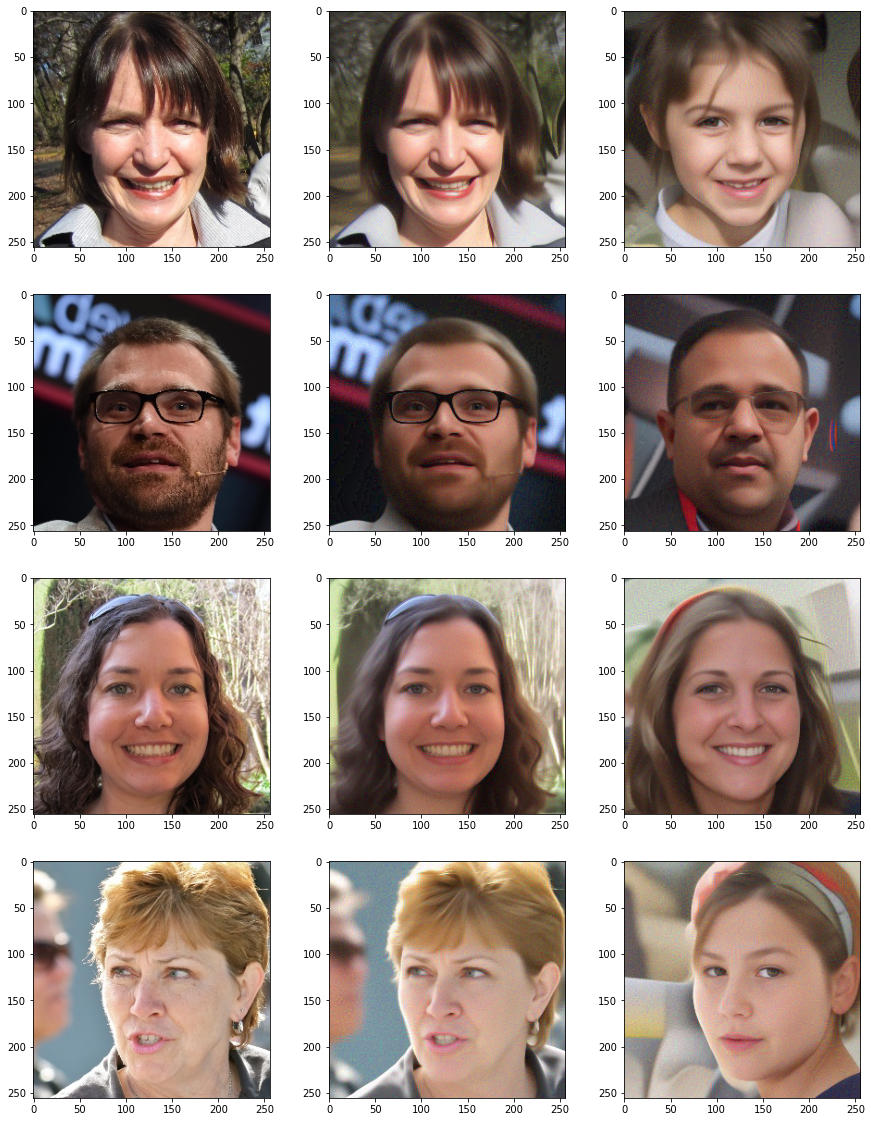

In [9]:
import matplotlib.pyplot as plt
idn = [10,11,15,20]
# torch.manual_seed(1)
batch_l = []
for idx in idn:
    img = image_data[idx]['img'][None]
    batch_l.append(img)
    if len(batch_l) == len(idn):
        batch_tensor = torch.cat(batch_l, dim=0)
        torch.cuda.empty_cache()
    #         gen_img = batch.detach().clone()
        id_images = batch_tensor.cuda()
    #         generated_img = Variable(gen_img, requires_grad = True)
    #         generated_img = generated_img.cuda()
    #         print(generated_img)

#             diff_batch = image_data[idx]['img'][None]
        attr_batch = batch_tensor*0.5+0.5
        attr_images = attr_batch.cuda()
        with torch.no_grad():
            id_vec = id_encoder.extract_feats(id_images)
            semantic_vec_true = model.encode(attr_images*2-1)
            encoded_vec = torch.cat((id_vec,semantic_vec_true), dim=1)
            semantic_vec = mlp(encoded_vec)
            xT_true = model.encode_stochastic(attr_images*2-1, semantic_vec_true, T=10)
            ori_img = model.render(xT_true, semantic_vec_true, T=10)
            generated_img = model.render(xT_true, semantic_vec, T=10)


fig, ax = plt.subplots(4, 3, figsize=(15, 20))
generated_image = generated_img.detach()
ax[0,0].imshow(attr_images[0].permute(1, 2, 0).cpu())
ax[0,1].imshow(ori_img[0].permute(1, 2, 0).cpu())
ax[0,2].imshow(generated_image[0].permute(1, 2, 0).cpu())
ax[1,0].imshow(attr_images[1].permute(1, 2, 0).cpu())
ax[1,1].imshow(ori_img[1].permute(1, 2, 0).cpu())
ax[1,2].imshow(generated_image[1].permute(1, 2, 0).cpu())
ax[2,0].imshow(attr_images[2].permute(1, 2, 0).cpu())
ax[2,1].imshow(ori_img[2].permute(1, 2, 0).cpu())
ax[2,2].imshow(generated_image[2].permute(1, 2, 0).cpu())
ax[3,0].imshow(attr_images[3].permute(1, 2, 0).cpu())
ax[3,1].imshow(ori_img[3].permute(1, 2, 0).cpu())
ax[3,2].imshow(generated_image[3].permute(1, 2, 0).cpu())

In [12]:
np.shape(id_vec)

torch.Size([1, 512])

In [ ]:
# 绘制loss曲线
fig, axs = plt.subplots(7, figsize=(10, 10))
axs[0].plot(id_loss_list)
axs[0].set_title('id_loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[1].plot(rec_loss_list)
axs[1].set_title('rec_loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[2].plot(l2_loss_list)
axs[2].set_title('l2_loss')
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('Loss')
axs[3].plot(latent_loss_list)
axs[3].set_title('latent_loss')
axs[3].set_xlabel('Batch')
axs[3].set_ylabel('Loss')
axs[4].plot(vgg_loss_list)
axs[4].set_title('vgg_loss')
axs[4].set_xlabel('Batch')
axs[4].set_ylabel('Loss')
axs[5].plot(landmark_loss_list)
axs[5].set_title('landmark_loss')
axs[5].set_xlabel('Batch')
axs[5].set_ylabel('Loss')
axs[6].plot(total_loss_list)
axs[6].set_title('total_loss')
axs[6].set_xlabel('Batch')
axs[6].set_ylabel('Loss')
plt.show()

In [60]:
Model_mlp_path = 'checkpoints/MLP/ID_VEC_ffhq70000_mlp.pt'
torch.save(mlp, Model_mlp_path)